In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/clash_1/train.csv')

In [ ]:
train_df.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [ ]:
train_df['visibility'].unique()

array([nan, 'unidentified', ' ', '-1m', 'unrecognized', 'unknown',
       '-1 km', '-1', 'empty', 'undefined', '-1km', '-1 m', 'missing'],
      dtype=object)

In [ ]:
train_df.drop(['visibility'], axis=1, inplace=True)

In [ ]:
train_df.head()

,datetime,datetime_iso,time-zone,temp,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [ ]:
# Function to preprocess datetime features
def process_datetime(df):
    df['datetime_iso'] = pd.to_datetime(df['datetime_iso'])
    df['year'] = df['datetime_iso'].dt.year
    df['month'] = df['datetime_iso'].dt.month
    df['day'] = df['datetime_iso'].dt.day
    df['hour'] = df['datetime_iso'].dt.hour
    df['dayofweek'] = df['datetime_iso'].dt.dayofweek
    return df

# Function to clean numeric columns
def clean_numeric_features(df):
    # Temperature columns
    temp_columns = ['temp', 'd_point', 'feels', 'min_temp', 'max_temp']
    for col in temp_columns:
        df[col] = df[col].astype(str).str.extract('([-+]?\d*\.?\d+)').astype(float)

    # Pressure
    df['prssr'] = df['prssr'].astype(str).str.replace(r'[hH][pP][aA]\.?', '', regex=True).str.strip()
    df['prssr'] = pd.to_numeric(df['prssr'], errors='coerce')

    # Humidity
    df['hum'] = df['hum'].astype(str).str.replace('%', '').astype(float)

    # Wind speed
    df['wind_spd'] = df['wind_spd'].astype(str).str.replace('m/s', '').astype(float)

    # Wind degree
    df['wind_deg'] = df['wind_deg'].astype(str).str.replace('°', '').astype(float)
    df['wind_deg'] = df['wind_deg'] % 360

    # Clouds
    df['clouds'] = df['clouds'].astype(str).str.replace('%', '').astype(float)

    return df

# Function to clean rain_1h column
def clean_rain_1h(df):
    if 'rain_1h' in df.columns:
        # Replace various zero representations with '0'
        zero_values = ['zero', '0 mm', '-1mm', 'no-rain', '0 milimeter', 'volume:0',
                      'nol', '0mm', 'no_rain', 'volume:zero', 'no rain']
        df['rain_1h'] = df['rain_1h'].replace(zero_values, '0')

        # Remove non-numeric characters and convert to float
        df['rain_1h'] = df['rain_1h'].astype(str).str.extract('([-+]?\d*\.?\d+)', expand=False)
        df['rain_1h'] = pd.to_numeric(df['rain_1h'], errors='coerce').fillna(0)
    return df

# Preprocess train data
train_df = process_datetime(train_df)
train_df = clean_numeric_features(train_df)
train_df = clean_rain_1h(train_df)

In [ ]:
train_df.head()

,datetime,datetime_iso,time-zone,temp,d_point,feels,min_temp,max_temp,prssr,sea_level,...,rain_1h,rain_3h,snow_1h,snow_3h,clouds,year,month,day,hour,dayofweek
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,23.89,25.76,24.28,25.22,1012.0,undetermined,...,0.00,0,NaN,NaN,100.0,1979,1,1,0,0
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,23.73,25.57,23.99,25.26,1012.0,NaN,...,0.00,0,0,0,100.0,1979,1,1,1,0
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,24.06,26.60,26.10,27.39,1012.0,NaN,...,0.00,volume:zero,NaN,NaN,99.0,1979,1,1,2,0
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,24.37,30.90,26.59,28.36,1012.0,NaN,...,0.13,nol,0,NaN,94.0,1979,1,1,3,0
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,25.05,31.54,26.58,28.31,1011.0,NaN,...,0.34,nol,NaN,0,100.0,1979,1,1,4,0


In [ ]:
train_df['dayofyear'] = train_df['datetime_iso'].dt.dayofyear  # Day of year (1-365/366)
train_df['weekofyear'] = train_df['datetime_iso'].dt.isocalendar().week  # Week of year (1-52/53)
train_df['quarter'] = train_df['datetime_iso'].dt.quarter  # Quarter of year (1-4)

In [ ]:
train_df.head()

,datetime,datetime_iso,time-zone,temp,d_point,feels,min_temp,max_temp,prssr,sea_level,...,snow_3h,clouds,year,month,day,hour,dayofweek,dayofyear,weekofyear,quarter
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,23.89,25.76,24.28,25.22,1012.0,undetermined,...,NaN,100.0,1979,1,1,0,0,1,1,1
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,23.73,25.57,23.99,25.26,1012.0,NaN,...,0,100.0,1979,1,1,1,0,1,1,1
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,24.06,26.60,26.10,27.39,1012.0,NaN,...,NaN,99.0,1979,1,1,2,0,1,1,1
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,24.37,30.90,26.59,28.36,1012.0,NaN,...,NaN,94.0,1979,1,1,3,0,1,1,1
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,25.05,31.54,26.58,28.31,1011.0,NaN,...,0,100.0,1979,1,1,4,0,1,1,1


In [ ]:
# Function to create cyclic features from datetime components
def create_cyclic_features(df):
    # Month: ranges from 1-12
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Day: ranges from 1-31
    max_days = 31  # Maximum possible days in a month
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / max_days)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / max_days)

    # Hour: ranges from 0-23
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Day of week: ranges from 0-6
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Day of year: ranges from 1-365/366
    max_days_year = 366  # Use 366 to account for leap years
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / max_days_year)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / max_days_year)

    # Week of year: ranges from 1-52/53
    max_weeks = 53  # Use 53 to account for years with 53 weeks
    df['weekofyear_sin'] = np.sin(2 * np.pi * df['weekofyear'] / max_weeks)
    df['weekofyear_cos'] = np.cos(2 * np.pi * df['weekofyear'] / max_weeks)

    # Quarter: ranges from 1-4
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

    return df

In [ ]:
# Complete preprocessing with datetime features and cyclic transformations
def preprocess_data(df):

    # Then, transform them into cyclic features
    df = create_cyclic_features(df)

    return df

# Example usage
train_df = preprocess_data(train_df)

In [ ]:
train_df.head()

,datetime,datetime_iso,time-zone,temp,d_point,feels,min_temp,max_temp,prssr,sea_level,...,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,weekofyear_sin,weekofyear_cos,quarter_sin,quarter_cos
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,23.89,25.76,24.28,25.22,1012.0,undetermined,...,0.000000,1.000000,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,23.73,25.57,23.99,25.26,1012.0,NaN,...,0.258819,0.965926,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,24.06,26.60,26.10,27.39,1012.0,NaN,...,0.500000,0.866025,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,24.37,30.90,26.59,28.36,1012.0,NaN,...,0.707107,0.707107,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,25.05,31.54,26.58,28.31,1011.0,NaN,...,0.866025,0.500000,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17


In [ ]:
pd.set_option('display.max_columns', None)



In [ ]:
print(train_df['temp'].max())

177.26


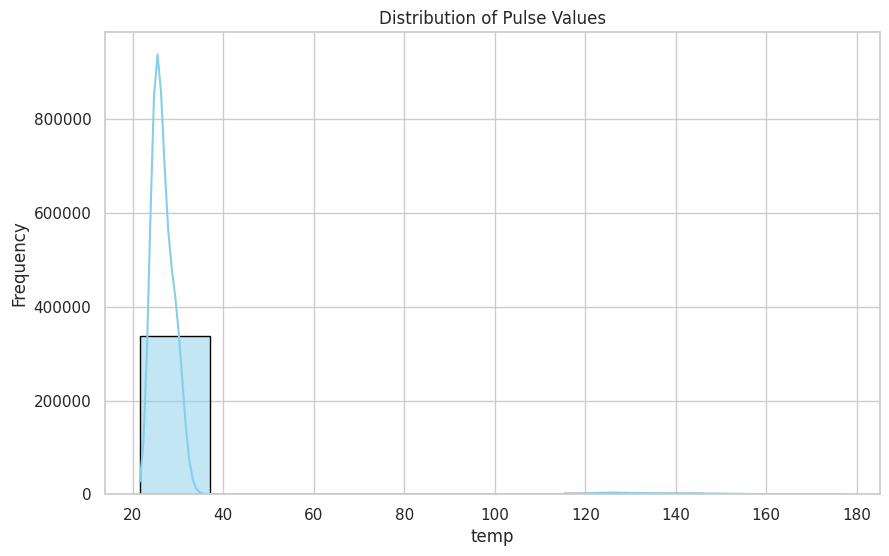

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(train_df['temp'], kde=True, bins=10, color='skyblue', edgecolor='black')

plt.title('Distribution of Pulse Values')
plt.xlabel('temp')
plt.ylabel('Frequency')
plt.show()


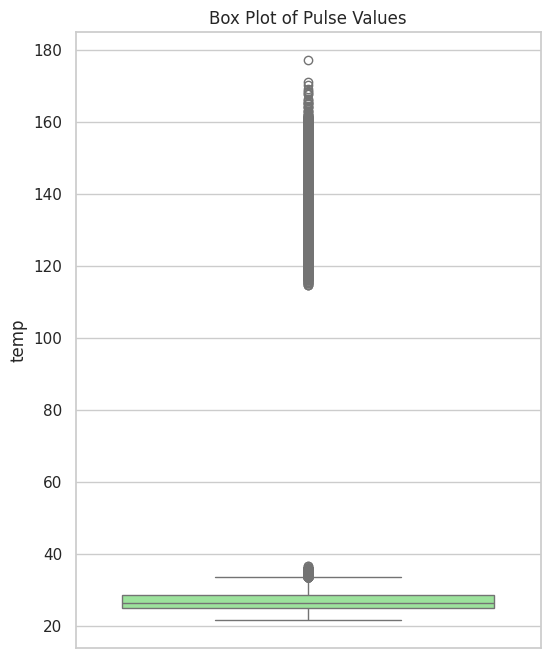

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=train_df['temp'], color='lightgreen')

plt.title('Box Plot of Pulse Values')
plt.ylabel('temp')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = train_df['temp'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = train_df['temp'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada train_dfFrame asli
train_df['temp'] = np.where(
    train_df['temp'] > uplimit, uplimit,
    np.where(train_df['temp'] < lolimit, lolimit, train_df['temp'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(train_df.head())

25th Percentile: 24.98
75th Percentile: 28.39
Upper Limit: 33.505 Lower Limit: 19.865000000000002
    datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  283996800 1979-01-01 00:00:00+00:00      28800  24.75    23.89  25.76   
1  284000400 1979-01-01 01:00:00+00:00      28800  24.58    23.73  25.57   
2  284004000 1979-01-01 02:00:00+00:00      28800  26.60    24.06  26.60   
3  284007600 1979-01-01 03:00:00+00:00      28800  27.31    24.37  30.90   
4  284011200 1979-01-01 04:00:00+00:00      28800  27.41    25.05  31.54   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     24.28     25.22  1012.0  undetermined           NaN  95.0      0.82   
1     23.99     25.26  1012.0           NaN           NaN  95.0      0.96   
2     26.10     27.39  1012.0           NaN  undetermined  86.0      1.22   
3     26.59     28.36  1012.0           NaN  undetermined  84.0      1.08   
4     26.58     28.31  1011.0           NaN  undetermined  8

In [ ]:
train_df.head()

,datetime,datetime_iso,time-zone,temp,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds,year,month,day,hour,dayofweek,dayofyear,weekofyear,quarter,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,weekofyear_sin,weekofyear_cos,quarter_sin,quarter_cos
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,0.00,0,NaN,NaN,100.0,1979,1,1,0,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.000000,1.000000,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0,0,0,100.0,1979,1,1,1,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.258819,0.965926,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,volume:zero,NaN,NaN,99.0,1979,1,1,2,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.500000,0.866025,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,nol,0,NaN,94.0,1979,1,1,3,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.707107,0.707107,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,nol,NaN,0,100.0,1979,1,1,4,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.866025,0.500000,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17


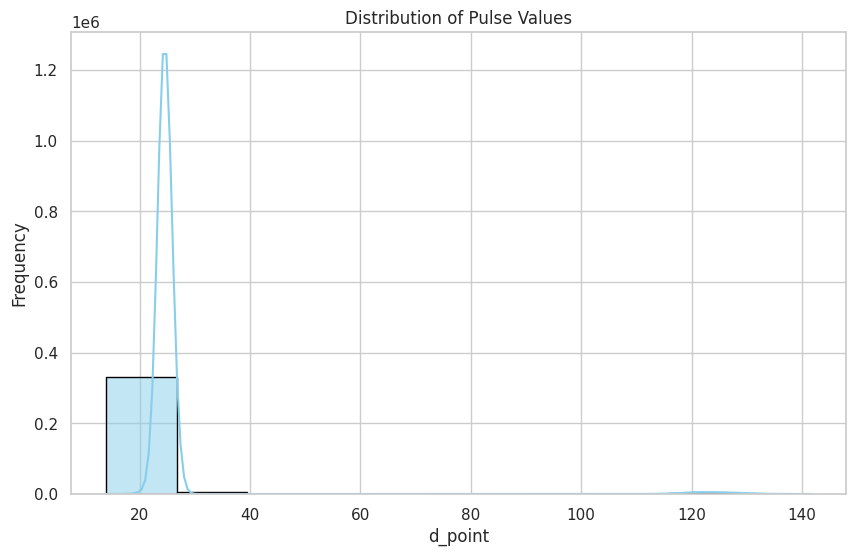

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(train_df['d_point'], kde=True, bins=10, color='skyblue', edgecolor='black')

plt.title('Distribution of Pulse Values')
plt.xlabel('d_point')
plt.ylabel('Frequency')
plt.show()


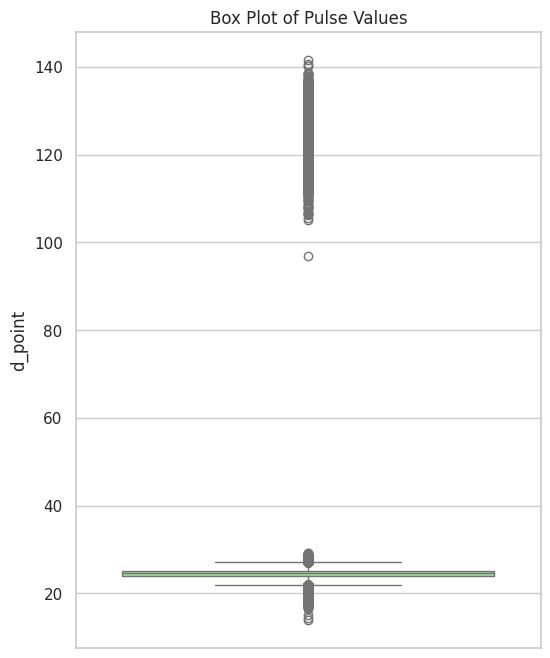

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=train_df['d_point'], color='lightgreen')

plt.title('Box Plot of Pulse Values')
plt.ylabel('d_point')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = train_df['d_point'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = train_df['d_point'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada train_dfFrame asli
train_df['d_point'] = np.where(
    train_df['d_point'] > uplimit, uplimit,
    np.where(train_df['d_point'] < lolimit, lolimit, train_df['d_point'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(train_df.head())

25th Percentile: 23.95
75th Percentile: 25.24
Upper Limit: 27.174999999999997 Lower Limit: 22.015
    datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  283996800 1979-01-01 00:00:00+00:00      28800  24.75    23.89  25.76   
1  284000400 1979-01-01 01:00:00+00:00      28800  24.58    23.73  25.57   
2  284004000 1979-01-01 02:00:00+00:00      28800  26.60    24.06  26.60   
3  284007600 1979-01-01 03:00:00+00:00      28800  27.31    24.37  30.90   
4  284011200 1979-01-01 04:00:00+00:00      28800  27.41    25.05  31.54   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     24.28     25.22  1012.0  undetermined           NaN  95.0      0.82   
1     23.99     25.26  1012.0           NaN           NaN  95.0      0.96   
2     26.10     27.39  1012.0           NaN  undetermined  86.0      1.22   
3     26.59     28.36  1012.0           NaN  undetermined  84.0      1.08   
4     26.58     28.31  1011.0           NaN  undetermined  8

In [ ]:
train_df.head()

,datetime,datetime_iso,time-zone,temp,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds,year,month,day,hour,dayofweek,dayofyear,weekofyear,quarter,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,weekofyear_sin,weekofyear_cos,quarter_sin,quarter_cos
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,0.00,0,NaN,NaN,100.0,1979,1,1,0,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.000000,1.000000,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0,0,0,100.0,1979,1,1,1,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.258819,0.965926,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,volume:zero,NaN,NaN,99.0,1979,1,1,2,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.500000,0.866025,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,nol,0,NaN,94.0,1979,1,1,3,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.707107,0.707107,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,nol,NaN,0,100.0,1979,1,1,4,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.866025,0.500000,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17


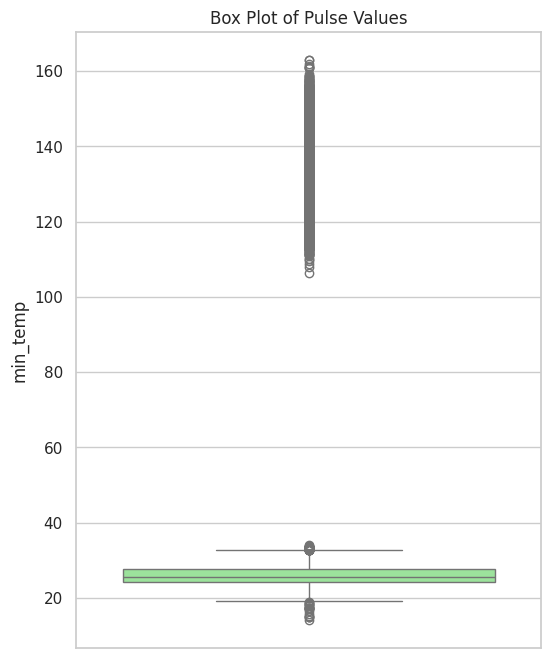

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=train_df['min_temp'], color='lightgreen')

plt.title('Box Plot of Pulse Values')
plt.ylabel('min_temp')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = train_df['min_temp'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = train_df['min_temp'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada train_dfFrame asli
train_df['min_temp'] = np.where(
    train_df['min_temp'] > uplimit, uplimit,
    np.where(train_df['min_temp'] < lolimit, lolimit, train_df['min_temp'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(train_df.head())

25th Percentile: 24.25
75th Percentile: 27.64
Upper Limit: 32.725 Lower Limit: 19.165
    datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  283996800 1979-01-01 00:00:00+00:00      28800  24.75    23.89  25.76   
1  284000400 1979-01-01 01:00:00+00:00      28800  24.58    23.73  25.57   
2  284004000 1979-01-01 02:00:00+00:00      28800  26.60    24.06  26.60   
3  284007600 1979-01-01 03:00:00+00:00      28800  27.31    24.37  30.90   
4  284011200 1979-01-01 04:00:00+00:00      28800  27.41    25.05  31.54   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     24.28     25.22  1012.0  undetermined           NaN  95.0      0.82   
1     23.99     25.26  1012.0           NaN           NaN  95.0      0.96   
2     26.10     27.39  1012.0           NaN  undetermined  86.0      1.22   
3     26.59     28.36  1012.0           NaN  undetermined  84.0      1.08   
4     26.58     28.31  1011.0           NaN  undetermined  87.0      0.8

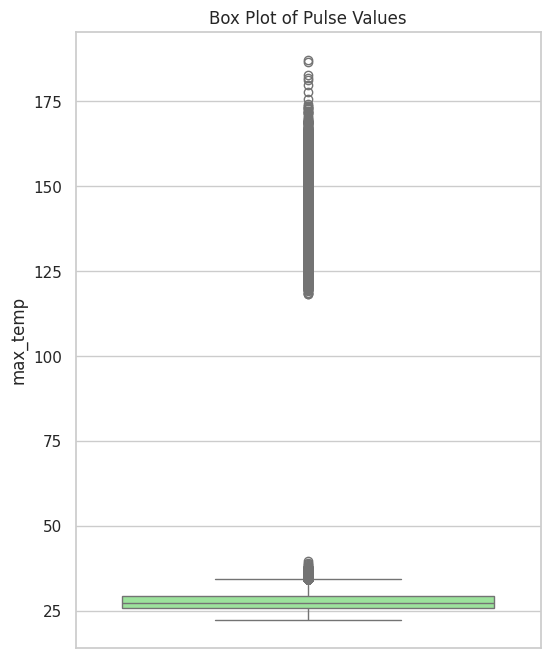

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=train_df['max_temp'], color='lightgreen')

plt.title('Box Plot of Pulse Values')
plt.ylabel('max_temp')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = train_df['max_temp'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = train_df['max_temp'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada train_dfFrame asli
train_df['max_temp'] = np.where(
    train_df['max_temp'] > uplimit, uplimit,
    np.where(train_df['max_temp'] < lolimit, lolimit, train_df['max_temp'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(train_df.head())

25th Percentile: 25.97
75th Percentile: 29.31
Upper Limit: 34.32 Lower Limit: 20.96
    datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  283996800 1979-01-01 00:00:00+00:00      28800  24.75    23.89  25.76   
1  284000400 1979-01-01 01:00:00+00:00      28800  24.58    23.73  25.57   
2  284004000 1979-01-01 02:00:00+00:00      28800  26.60    24.06  26.60   
3  284007600 1979-01-01 03:00:00+00:00      28800  27.31    24.37  30.90   
4  284011200 1979-01-01 04:00:00+00:00      28800  27.41    25.05  31.54   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     24.28     25.22  1012.0  undetermined           NaN  95.0      0.82   
1     23.99     25.26  1012.0           NaN           NaN  95.0      0.96   
2     26.10     27.39  1012.0           NaN  undetermined  86.0      1.22   
3     26.59     28.36  1012.0           NaN  undetermined  84.0      1.08   
4     26.58     28.31  1011.0           NaN  undetermined  87.0      0.86 

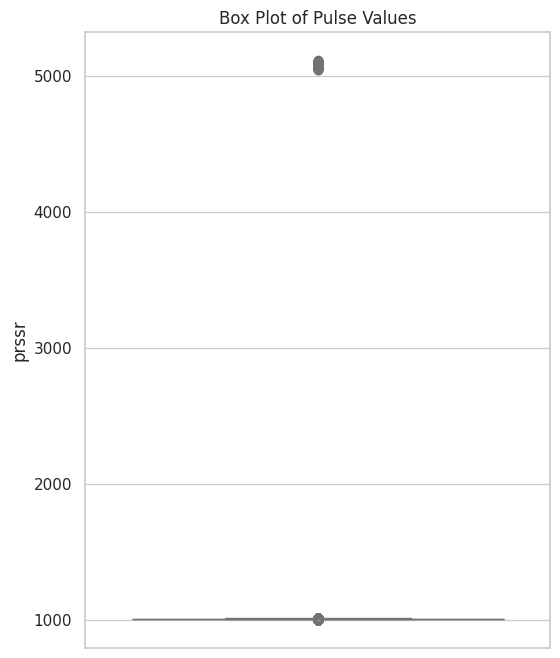

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=train_df['prssr'], color='lightgreen')

plt.title('Box Plot of Pulse Values')
plt.ylabel('prssr')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = train_df['prssr'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = train_df['prssr'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada train_dfFrame asli
train_df['prssr'] = np.where(
    train_df['prssr'] > uplimit, uplimit,
    np.where(train_df['prssr'] < lolimit, lolimit, train_df['prssr'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(train_df.head())

25th Percentile: 1009.0
75th Percentile: 1011.0
Upper Limit: 1014.0 Lower Limit: 1006.0
    datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  283996800 1979-01-01 00:00:00+00:00      28800  24.75    23.89  25.76   
1  284000400 1979-01-01 01:00:00+00:00      28800  24.58    23.73  25.57   
2  284004000 1979-01-01 02:00:00+00:00      28800  26.60    24.06  26.60   
3  284007600 1979-01-01 03:00:00+00:00      28800  27.31    24.37  30.90   
4  284011200 1979-01-01 04:00:00+00:00      28800  27.41    25.05  31.54   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     24.28     25.22  1012.0  undetermined           NaN  95.0      0.82   
1     23.99     25.26  1012.0           NaN           NaN  95.0      0.96   
2     26.10     27.39  1012.0           NaN  undetermined  86.0      1.22   
3     26.59     28.36  1012.0           NaN  undetermined  84.0      1.08   
4     26.58     28.31  1011.0           NaN  undetermined  87.0      0

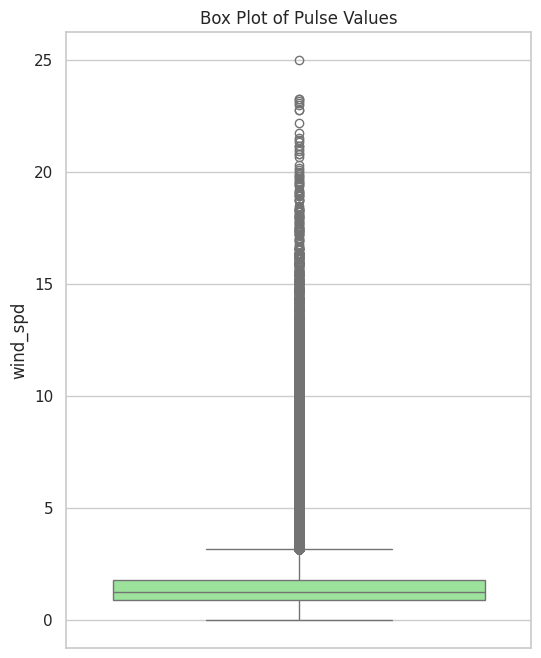

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=train_df['wind_spd'], color='lightgreen')

plt.title('Box Plot of Pulse Values')
plt.ylabel('wind_spd')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = train_df['wind_spd'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = train_df['wind_spd'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada train_dfFrame asli
train_df['wind_spd'] = np.where(
    train_df['wind_spd'] > uplimit, uplimit,
    np.where(train_df['wind_spd'] < lolimit, lolimit, train_df['wind_spd'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(train_df.head())

25th Percentile: 0.88
75th Percentile: 1.8
Upper Limit: 3.18 Lower Limit: -0.5000000000000001
    datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  283996800 1979-01-01 00:00:00+00:00      28800  24.75    23.89  25.76   
1  284000400 1979-01-01 01:00:00+00:00      28800  24.58    23.73  25.57   
2  284004000 1979-01-01 02:00:00+00:00      28800  26.60    24.06  26.60   
3  284007600 1979-01-01 03:00:00+00:00      28800  27.31    24.37  30.90   
4  284011200 1979-01-01 04:00:00+00:00      28800  27.41    25.05  31.54   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     24.28     25.22  1012.0  undetermined           NaN  95.0      0.82   
1     23.99     25.26  1012.0           NaN           NaN  95.0      0.96   
2     26.10     27.39  1012.0           NaN  undetermined  86.0      1.22   
3     26.59     28.36  1012.0           NaN  undetermined  84.0      1.08   
4     26.58     28.31  1011.0           NaN  undetermined  87.0 

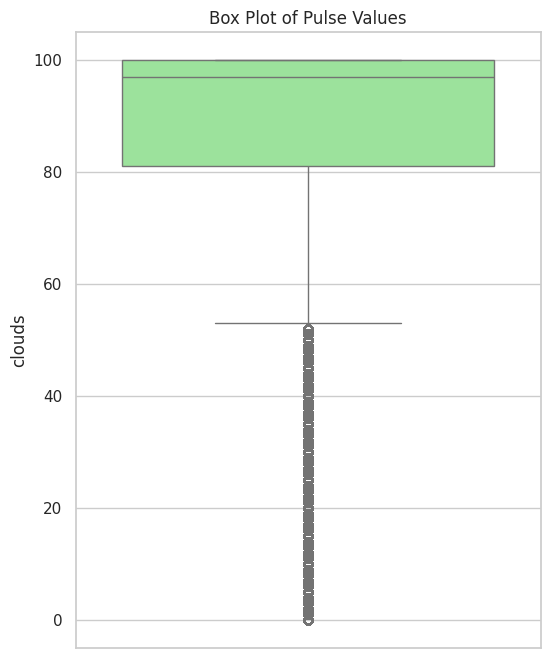

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=train_df['clouds'], color='lightgreen')

plt.title('Box Plot of Pulse Values')
plt.ylabel('clouds')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = train_df['clouds'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = train_df['clouds'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada train_dfFrame asli
train_df['clouds'] = np.where(
    train_df['clouds'] > uplimit, uplimit,
    np.where(train_df['clouds'] < lolimit, lolimit, train_df['clouds'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(train_df.head())

25th Percentile: 81.0
75th Percentile: 100.0
Upper Limit: 128.5 Lower Limit: 52.5
    datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  283996800 1979-01-01 00:00:00+00:00      28800  24.75    23.89  25.76   
1  284000400 1979-01-01 01:00:00+00:00      28800  24.58    23.73  25.57   
2  284004000 1979-01-01 02:00:00+00:00      28800  26.60    24.06  26.60   
3  284007600 1979-01-01 03:00:00+00:00      28800  27.31    24.37  30.90   
4  284011200 1979-01-01 04:00:00+00:00      28800  27.41    25.05  31.54   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     24.28     25.22  1012.0  undetermined           NaN  95.0      0.82   
1     23.99     25.26  1012.0           NaN           NaN  95.0      0.96   
2     26.10     27.39  1012.0           NaN  undetermined  86.0      1.22   
3     26.59     28.36  1012.0           NaN  undetermined  84.0      1.08   
4     26.58     28.31  1011.0           NaN  undetermined  87.0      0.86   

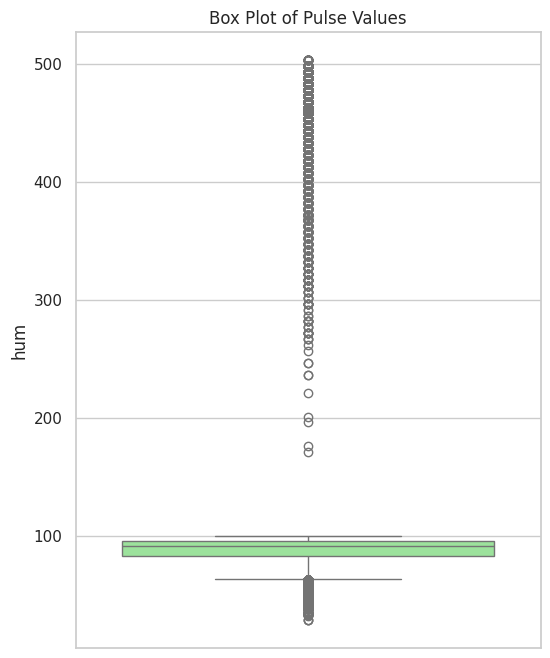

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(y=train_df['hum'], color='lightgreen')

plt.title('Box Plot of Pulse Values')
plt.ylabel('hum')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = train_df['hum'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = train_df['hum'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada train_dfFrame asli
train_df['hum'] = np.where(
    train_df['hum'] > uplimit, uplimit,
    np.where(train_df['hum'] < lolimit, lolimit, train_df['hum'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(train_df.head())

25th Percentile: 83.0
75th Percentile: 96.0
Upper Limit: 115.5 Lower Limit: 63.5
    datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  283996800 1979-01-01 00:00:00+00:00      28800  24.75    23.89  25.76   
1  284000400 1979-01-01 01:00:00+00:00      28800  24.58    23.73  25.57   
2  284004000 1979-01-01 02:00:00+00:00      28800  26.60    24.06  26.60   
3  284007600 1979-01-01 03:00:00+00:00      28800  27.31    24.37  30.90   
4  284011200 1979-01-01 04:00:00+00:00      28800  27.41    25.05  31.54   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     24.28     25.22  1012.0  undetermined           NaN  95.0      0.82   
1     23.99     25.26  1012.0           NaN           NaN  95.0      0.96   
2     26.10     27.39  1012.0           NaN  undetermined  86.0      1.22   
3     26.59     28.36  1012.0           NaN  undetermined  84.0      1.08   
4     26.58     28.31  1011.0           NaN  undetermined  87.0      0.86   


In [ ]:
# Function to create cyclic features for wind direction
def create_wind_cyclic_features(df, wind_deg_column='wind_deg'):
    # Wind direction is measured in degrees from 0 to 360
    df['wind_deg_sin'] = np.sin(np.radians(df[wind_deg_column]))
    df['wind_deg_cos'] = np.cos(np.radians(df[wind_deg_column]))
    return df

# Example usage
train_df = create_wind_cyclic_features(train_df)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   datetime        341880 non-null  int64              
 1   datetime_iso    341880 non-null  datetime64[ns, UTC]
 2   time-zone       341880 non-null  int64              
 3   temp            341880 non-null  float64            
 4   d_point         341880 non-null  float64            
 5   feels           341880 non-null  float64            
 6   min_temp        341880 non-null  float64            
 7   max_temp        341880 non-null  float64            
 8   prssr           341880 non-null  float64            
 9   sea_level       192964 non-null  object             
 10  grnd_level      192919 non-null  object             
 11  hum             341880 non-null  float64            
 12  wind_spd        341880 non-null  float64            
 13  wind_deg      

In [ ]:
train_df.head()

,datetime,datetime_iso,time-zone,temp,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds,year,month,day,hour,dayofweek,dayofyear,weekofyear,quarter,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,weekofyear_sin,weekofyear_cos,quarter_sin,quarter_cos,wind_deg_sin,wind_deg_cos
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,0.00,0,NaN,NaN,100.0,1979,1,1,0,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.000000,1.000000,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17,-0.642788,0.766044
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0,0,0,100.0,1979,1,1,1,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.258819,0.965926,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17,-0.374607,0.927184
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,volume:zero,NaN,NaN,99.0,1979,1,1,2,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.500000,0.866025,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17,-0.358368,0.933580
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,nol,0,NaN,94.0,1979,1,1,3,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.707107,0.707107,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17,-0.309017,0.951057
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,nol,NaN,0,100.0,1979,1,1,4,0,1,1,1,0.5,0.866025,0.201299,0.97953,0.866025,0.500000,0.0,1.0,0.017166,0.999853,0.118273,0.992981,1.0,6.123234e-17,-0.406737,0.913545


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   datetime        341880 non-null  int64              
 1   datetime_iso    341880 non-null  datetime64[ns, UTC]
 2   time-zone       341880 non-null  int64              
 3   temp            341880 non-null  float64            
 4   d_point         341880 non-null  float64            
 5   feels           341880 non-null  float64            
 6   min_temp        341880 non-null  float64            
 7   max_temp        341880 non-null  float64            
 8   prssr           341880 non-null  float64            
 9   sea_level       192964 non-null  object             
 10  grnd_level      192919 non-null  object             
 11  hum             341880 non-null  float64            
 12  wind_spd        341880 non-null  float64            
 13  wind_deg      

In [ ]:
train_df['temp'].unique()

array([24.75, 24.58, 26.6 , ..., 21.99, 22.06, 21.95])

In [ ]:
train_df.drop(['sea_level', 'datetime' , 'time-zone', 'rain_3h', 'snow_1h', 'snow_3h', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter' , 'wind_deg'], axis=1, inplace=True)

In [ ]:
train_df.drop(['grnd_level'], axis=1, inplace=True)

In [ ]:
def create_rain_prediction_features(df):
    """
    Create features specifically for rain prediction.

    Parameters:
    -----------
    df : pandas DataFrame
        Input weather dataframe with all weather variables
    """

    # Create a copy to avoid modifying original data
    result_df = df.copy()

    # Sort by datetime to ensure correct feature creation
    result_df = result_df.sort_values('datetime_iso')

    # 1. Key weather indicators that usually precede rain
    # Humidity features

    result_df['temp_lag_1'] = result_df['temp'].shift(1)
    result_df['temp_lag_2'] = result_df['temp'].shift(2)
    result_df['temp_lag_3'] = result_df['temp'].shift(3)

    # Rolling mean and standard deviation over a 3-hour window
    result_df['temp_rolling_mean_3h'] = result_df['temp'].rolling(window=3, min_periods=1).mean()
    result_df['temp_rolling_std_3h'] = result_df['temp'].rolling(window=3, min_periods=1).std()
    result_df['temp_range'] = result_df['max_temp'] - result_df['min_temp']

    result_df['wind_spd_rolling_mean_3h'] = result_df['wind_spd'].rolling(window=3, min_periods=1).mean()
    result_df['wind_spd_rolling_std_3h'] = result_df['wind_spd'].rolling(window=3, min_periods=1).std()

    # ---------------------------
    # Humidity and cloud interaction
    # ---------------------------
    # Ratio of humidity to cloud cover (avoiding division by zero)
    result_df['hum_to_clouds_ratio'] = result_df['hum'] / (result_df['clouds'] + 1e-5)

    result_df['hum_lag_1'] = result_df['hum'].shift(1)
    result_df['hum_lag_2'] = result_df['hum'].shift(2)
    result_df['hum_lag_3'] = result_df['hum'].shift(3)
    result_df['hum_rolling_mean_6h'] = result_df['hum'].rolling(window=6, min_periods=1).mean()

    # Pressure changes (important for rain prediction)
    result_df['prssr_change_1h'] = result_df['prssr'].diff()
    result_df['prssr_change_3h'] = result_df['prssr'].diff(3)
    result_df['prssr_rolling_mean_6h'] = result_df['prssr'].rolling(window=6, min_periods=1).mean()

    # Temperature and dew point difference (important for precipitation)
    result_df['temp_dpoint_diff'] = result_df['temp'] - result_df['d_point']
    result_df['temp_dpoint_diff_lag1'] = result_df['temp_dpoint_diff'].shift(1)

    # Cloud cover features
    result_df['clouds_lag_1'] = result_df['clouds'].shift(1)
    result_df['clouds_lag_2'] = result_df['clouds'].shift(2)

    # Wind features
    result_df['wind_spd_lag_1'] = result_df['wind_spd'].shift(1)
    result_df['wind_spd_change'] = result_df['wind_spd'].diff()

    # 4. Categorical features
    # Time of day might affect rain patterns
    result_df['is_daytime'] = (result_df['hour'] >= 6) & (result_df['hour'] <= 18)

    # 5. Combined indicators
    result_df['humid_and_cloudy'] = ((result_df['hum'] > 80) & (result_df['clouds'] > 80)).astype(int)

    # result_df['rain_1h_lag_1'] = result_df['rain_1h'].shift(1)
    # result_df['rain_1h_lag_2'] = result_df['rain_1h'].shift(2)
    # result_df['rain_1h_lag_3'] = result_df['rain_1h'].shift(3)

    # # 3. Time-based rain statistics
    # result_df['rain_moving_avg_3h'] = result_df['rain_1h'].rolling(window=3, min_periods=1).mean()
    # result_df['rain_moving_avg_6h'] = result_df['rain_1h'].rolling(window=6, min_periods=1).mean()

    return result_df

# Example usage:
# Buat fitur
train_df = create_rain_prediction_features(train_df)

# Fitur untuk model prediksi hujan
prediction_features = [
    'hum_lag_1', 'hum_rolling_mean_6h',
    'prssr_change_1h', 'prssr_change_3h',
    'temp_dpoint_diff', 'clouds_lag_1',
    'wind_spd_lag_1', 'humid_and_cloudy', 'temp_lag_1', 'temp_rolling_mean_3h', 'temp_rolling_std_3h', 'temp_range', 'wind_spd_rolling_mean_3h',
    'wind_spd_rolling_std_3h', 'hum_to_clouds_ratio',
]

# Target
target = 'rain_1h'

In [ ]:
train_df.drop(['datetime_iso', 'hour'], axis=1, inplace=True)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   temp                      341880 non-null  float64
 1   d_point                   341880 non-null  float64
 2   feels                     341880 non-null  float64
 3   min_temp                  341880 non-null  float64
 4   max_temp                  341880 non-null  float64
 5   prssr                     341880 non-null  float64
 6   hum                       341880 non-null  float64
 7   wind_spd                  341880 non-null  float64
 8   rain_1h                   341880 non-null  float64
 9   clouds                    341880 non-null  float64
 10  year                      341880 non-null  int32  
 11  month_sin                 341880 non-null  float64
 12  month_cos                 341880 non-null  float64
 13  day_sin                   341880 non-null  f

In [ ]:
for column in train_df.columns:
    train_df[column].fillna(train_df[column].mode()[0], inplace=True)

<ipython-input-48-405791c7e208>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[column].fillna(train_df[column].mode()[0], inplace=True)
<ipython-input-48-405791c7e208>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   temp                      341880 non-null  float64
 1   d_point                   341880 non-null  float64
 2   feels                     341880 non-null  float64
 3   min_temp                  341880 non-null  float64
 4   max_temp                  341880 non-null  float64
 5   prssr                     341880 non-null  float64
 6   hum                       341880 non-null  float64
 7   wind_spd                  341880 non-null  float64
 8   rain_1h                   341880 non-null  float64
 9   clouds                    341880 non-null  float64
 10  year                      341880 non-null  int32  
 11  month_sin                 341880 non-null  float64
 12  month_cos                 341880 non-null  float64
 13  day_sin                   341880 non-null  f

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/clash_1/test.csv')

In [ ]:
test_df.drop(['visibility'], axis=1, inplace=True)

In [ ]:
# Function to preprocess datetime features
def process_datetime(df):
    df['datetime_iso'] = pd.to_datetime(df['datetime_iso'])
    df['year'] = df['datetime_iso'].dt.year
    df['month'] = df['datetime_iso'].dt.month
    df['day'] = df['datetime_iso'].dt.day
    df['hour'] = df['datetime_iso'].dt.hour
    df['dayofweek'] = df['datetime_iso'].dt.dayofweek
    return df

# Function to clean numeric columns
def clean_numeric_features(df):
    # Temperature columns
    temp_columns = ['temp', 'd_point', 'feels', 'min_temp', 'max_temp']
    for col in temp_columns:
        df[col] = df[col].astype(str).str.extract('([-+]?\d*\.?\d+)').astype(float)

    # Pressure
    df['prssr'] = df['prssr'].astype(str).str.replace(r'[hH][pP][aA]\.?', '', regex=True).str.strip()
    df['prssr'] = pd.to_numeric(df['prssr'], errors='coerce')

    # Humidity
    df['hum'] = df['hum'].astype(str).str.replace('%', '').astype(float)

    # Wind speed
    df['wind_spd'] = df['wind_spd'].astype(str).str.replace('m/s', '').astype(float)

    # Wind degree
    df['wind_deg'] = df['wind_deg'].astype(str).str.replace('°', '').astype(float)
    df['wind_deg'] = df['wind_deg'] % 360

    # Clouds
    df['clouds'] = df['clouds'].astype(str).str.replace('%', '').astype(float)

    return df

# Function to clean rain_1h column
def clean_rain_1h(df):
    if 'rain_1h' in df.columns:
        # Replace various zero representations with '0'
        zero_values = ['zero', '0 mm', '-1mm', 'no-rain', '0 milimeter', 'volume:0',
                      'nol', '0mm', 'no_rain', 'volume:zero', 'no rain']
        df['rain_1h'] = df['rain_1h'].replace(zero_values, '0')

        # Remove non-numeric characters and convert to float
        df['rain_1h'] = df['rain_1h'].astype(str).str.extract('([-+]?\d*\.?\d+)', expand=False)
        df['rain_1h'] = pd.to_numeric(df['rain_1h'], errors='coerce').fillna(0)
    return df

# Preprocess train data
test_df = process_datetime(test_df)
test_df = clean_numeric_features(test_df)
test_df = clean_rain_1h(test_df)

In [ ]:
test_df['dayofyear'] = test_df['datetime_iso'].dt.dayofyear  # Day of year (1-365/366)
test_df['weekofyear'] = test_df['datetime_iso'].dt.isocalendar().week  # Week of year (1-52/53)
test_df['quarter'] = test_df['datetime_iso'].dt.quarter  # Quarter of year (1-4)

In [ ]:
# Complete preprocessing with datetime features and cyclic transformations
def preprocess_data(df):

    # Then, transform them into cyclic features
    df = create_cyclic_features(df)

    return df

# Example usage
test_df = preprocess_data(test_df)

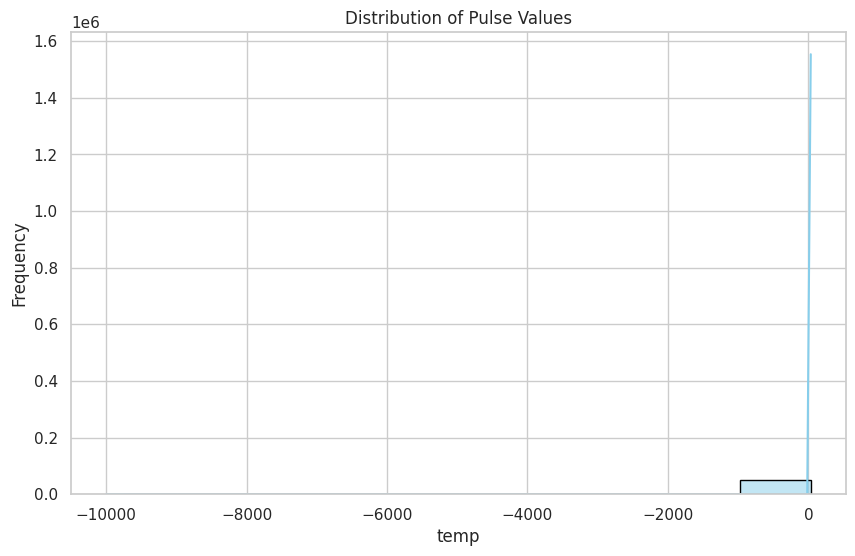

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(test_df['temp'], kde=True, bins=10, color='skyblue', edgecolor='black')

plt.title('Distribution of Pulse Values')
plt.xlabel('temp')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['temp'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['temp'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['temp'] = np.where(
    test_df['temp'] > uplimit, uplimit,
    np.where(test_df['temp'] < lolimit, lolimit, test_df['temp'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 25.51
75th Percentile: 29.0
Upper Limit: 34.235 Lower Limit: 20.275000000000006
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined  undetermin

In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['d_point'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['d_point'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['d_point'] = np.where(
    test_df['d_point'] > uplimit, uplimit,
    np.where(test_df['d_point'] < lolimit, lolimit, test_df['d_point'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 24.34
75th Percentile: 25.53
Upper Limit: 27.315000000000005 Lower Limit: 22.555
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined  undetermi

In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['feels'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['feels'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['feels'] = np.where(
    test_df['feels'] > uplimit, uplimit,
    np.where(test_df['feels'] < lolimit, lolimit, test_df['feels'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 26.27
75th Percentile: 34.77
Upper Limit: 47.52000000000001 Lower Limit: 13.519999999999994
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined

In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['min_temp'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['min_temp'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['min_temp'] = np.where(
    test_df['min_temp'] > uplimit, uplimit,
    np.where(test_df['min_temp'] < lolimit, lolimit, test_df['min_temp'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 24.76
75th Percentile: 28.02
Upper Limit: 32.91 Lower Limit: 19.870000000000005
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined  undetermin

In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['max_temp'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['max_temp'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['max_temp'] = np.where(
    test_df['max_temp'] > uplimit, uplimit,
    np.where(test_df['max_temp'] < lolimit, lolimit, test_df['max_temp'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 26.6
75th Percentile: 30.02
Upper Limit: 35.15 Lower Limit: 21.470000000000006
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined  undetermine

In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['prssr'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['prssr'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['prssr'] = np.where(
    test_df['prssr'] > uplimit, uplimit,
    np.where(test_df['prssr'] < lolimit, lolimit, test_df['prssr'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 1009.0
75th Percentile: 1011.0
Upper Limit: 1014.0 Lower Limit: 1006.0
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined  undetermined  74.0 

In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['hum'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['hum'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['hum'] = np.where(
    test_df['hum'] > uplimit, uplimit,
    np.where(test_df['hum'] < lolimit, lolimit, test_df['hum'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 82.0
75th Percentile: 95.0
Upper Limit: 114.5 Lower Limit: 62.5
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined  undetermined  74.0      1.

In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['wind_spd'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['wind_spd'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['wind_spd'] = np.where(
    test_df['wind_spd'] > uplimit, uplimit,
    np.where(test_df['wind_spd'] < lolimit, lolimit, test_df['wind_spd'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 0.89
75th Percentile: 1.76
Upper Limit: 3.065 Lower Limit: -0.4149999999999999
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined  undetermine

In [ ]:
# Menghitung persentil ke-25 dan ke-75
percentile25 = test_df['clouds'].quantile(0.25)
print("25th Percentile:", percentile25)

percentile75 = test_df['clouds'].quantile(0.75)
print("75th Percentile:", percentile75)

# Menghitung rentang interkuartil (IQR)
iqr = percentile75 - percentile25

# Menghitung batas atas dan batas bawah untuk pencilan
uplimit = percentile75 + 1.5 * iqr
lolimit = percentile25 - 1.5 * iqr
print("Upper Limit:", uplimit, "Lower Limit:", lolimit)

# Melakukan capping langsung pada test_dfFrame asli
test_df['clouds'] = np.where(
    test_df['clouds'] > uplimit, uplimit,
    np.where(test_df['clouds'] < lolimit, lolimit, test_df['clouds'])
)

# Menampilkan beberapa baris pertama untuk memeriksa perubahan
print(test_df.head())

25th Percentile: 80.0
75th Percentile: 100.0
Upper Limit: 130.0 Lower Limit: 50.0
     datetime              datetime_iso  time-zone   temp  d_point  feels  \
0  1514764800 2018-01-01 00:00:00+00:00      28800  26.59    23.66  26.59   
1  1514768400 2018-01-01 01:00:00+00:00      28800  26.51    24.92  26.51   
2  1514772000 2018-01-01 02:00:00+00:00      28800  28.68    25.71  34.68   
3  1514775600 2018-01-01 03:00:00+00:00      28800  28.84    25.25  34.51   
4  1514779200 2018-01-01 04:00:00+00:00      28800  29.75    24.62  35.38   

   min_temp  max_temp   prssr     sea_level    grnd_level   hum  wind_spd  \
0     26.02     27.16  1009.0           NaN  undetermined  84.0      1.45   
1     26.06     28.04  1009.0           NaN  undetermined  91.0      1.67   
2     28.03     29.30  1009.0           NaN           NaN  84.0      1.72   
3     28.52     29.08  1008.0           NaN           NaN  81.0      1.49   
4     29.31     30.57  1007.0  undetermined  undetermined  74.0      1

In [ ]:
# Function to create cyclic features for wind direction
def create_wind_cyclic_features(df, wind_deg_column='wind_deg'):
    # Wind direction is measured in degrees from 0 to 360
    df['wind_deg_sin'] = np.sin(np.radians(df[wind_deg_column]))
    df['wind_deg_cos'] = np.cos(np.radians(df[wind_deg_column]))
    return df

# Example usage
test_df = create_wind_cyclic_features(test_df)

In [ ]:
test_df.drop(['sea_level', 'datetime' , 'time-zone', 'rain_3h', 'snow_1h', 'snow_3h', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter' , 'wind_deg', 'grnd_level'], axis=1, inplace=True)

In [ ]:
# Example usage:
# Buat fitur
train_df = create_rain_prediction_features(train_df)

# Fitur untuk model prediksi hujan
prediction_features = [
    'hum_lag_1', 'hum_rolling_mean_6h',
    'prssr_change_1h', 'prssr_change_3h',
    'temp_dpoint_diff', 'clouds_lag_1',
    'wind_spd_lag_1', 'humid_and_cloudy', 'temp_lag_1', 'temp_rolling_mean_3h', 'temp_rolling_std_3h', 'temp_range', 'wind_spd_rolling_mean_3h',
    'wind_spd_rolling_std_3h', 'hum_to_clouds_ratio',
]

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49368 entries, 0 to 49367
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   datetime_iso              49368 non-null  datetime64[ns, UTC]
 1   temp                      49368 non-null  float64            
 2   d_point                   49367 non-null  float64            
 3   feels                     49368 non-null  float64            
 4   min_temp                  49368 non-null  float64            
 5   max_temp                  49368 non-null  float64            
 6   prssr                     49368 non-null  float64            
 7   hum                       49368 non-null  float64            
 8   wind_spd                  49368 non-null  float64            
 9   clouds                    49368 non-null  float64            
 10  year                      49368 non-null  int32              
 11  hour           

In [ ]:
test_df.drop(['datetime_iso', 'hour'], axis=1, inplace=True)

In [ ]:
for column in test_df.columns:
    test_df[column].fillna(test_df[column].mode()[0], inplace=True)

<ipython-input-71-5bd58db86f82>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[column].fillna(test_df[column].mode()[0], inplace=True)
<ipython-input-71-5bd58db86f82>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [ ]:
!pip install catboost

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
categorical_cols = train_df.select_dtypes(include=['object', 'bool']).columns
le = LabelEncoder()
for col in categorical_cols:
    train_df[col] = le.fit_transform(train_df[col])

In [ ]:
categorical_cols = test_df.select_dtypes(include=['object', 'bool']).columns
le = LabelEncoder()
for col in categorical_cols:
    test_df[col] = le.fit_transform(test_df[col])

In [ ]:
from sklearn.preprocessing import StandardScaler # Make sure to import StandardScaler

# Define the feature and target variables
x_train = train_df.drop(columns=['rain_1h'])
y_train = train_df['rain_1h']
x_test = test_df
# Get the column names from the training data
train_columns = x_train.columns

# Ensure x_test has the same columns and order as x_train
x_test = x_test.reindex(columns=train_columns)  # Reorder/add missing columns, fill with NaN if necessary

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric columns for training data
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

# Convert the scaled arrays back to DataFrames to use .head()
X_train_scaled = pd.DataFrame(X_train_scaled, columns=x_train.columns, index=x_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=x_test.columns, index=x_test.index)

# Show the final DataFrames
print(X_train_scaled.head())
print(X_test_scaled.head())

       temp   d_point     feels  min_temp  max_temp     prssr       hum  \
0 -0.880863 -0.727756 -0.350184 -0.770760 -1.099450  1.082028  0.589086   
1 -0.954480 -0.888193 -0.362661 -0.899175 -1.082295  1.082028  0.589086   
2 -0.079733 -0.557291 -0.295024  0.035158 -0.168821  1.082028 -0.344288   
3  0.227727 -0.246444 -0.012659  0.252136  0.247175  1.082028 -0.551704   
4  0.271032  0.435413  0.029367  0.247708  0.225732  0.543647 -0.240580   

   wind_spd    clouds      year  month_sin  month_cos   day_sin   day_cos  \
0 -0.797734  0.719652 -1.688169   0.715212   1.225308  0.280308  1.424134   
1 -0.606087  0.719652 -1.688169   0.715212   1.225308  0.280308  1.424134   
2 -0.250171  0.660346 -1.688169   0.715212   1.225308  0.280308  1.424134   
3 -0.441818  0.363817 -1.688169   0.715212   1.225308  0.280308  1.424134   
4 -0.742978  0.719652 -1.688169   0.715212   1.225308  0.280308  1.424134   

       hour_sin  hour_cos  dayofweek_sin  dayofweek_cos  dayofyear_sin  \
0  2.620311e

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the CatBoostRegressor with GPU settings
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100,
    random_seed=42,
    # task_type='GPU',          # Enable GPU training
    # devices='0',              # Use first GPU (you can specify multiple GPUs like '0:1:2')
    # gpu_ram_part=0.95         # Fraction of GPU memory to use (95% in this case)
)

# Train the model
# Note: CatBoost automatically handles data transfer to GPU
cat_model.fit(X_train_scaled, y_train)

# Predict on both training and test sets
y_train_pred = cat_model.predict(X_train_scaled)
y_pred_cat = cat_model.predict(X_test_scaled)

# Calculate RMSE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"Training RMSE (CatBoostRegressor): {rmse_train:.4f}")
print("\nPredictions on Test Data (CatBoostRegressor):")
print(y_pred_cat)

0:	learn: 0.8730834	total: 448ms	remaining: 7m 27s
100:	learn: 0.1349380	total: 22s	remaining: 3m 16s
200:	learn: 0.0921610	total: 38.2s	remaining: 2m 31s
300:	learn: 0.0760633	total: 48.8s	remaining: 1m 53s
400:	learn: 0.0662388	total: 59.4s	remaining: 1m 28s
500:	learn: 0.0590841	total: 1m 8s	remaining: 1m 8s
600:	learn: 0.0538353	total: 1m 19s	remaining: 52.5s
700:	learn: 0.0498507	total: 1m 29s	remaining: 38.3s
800:	learn: 0.0464019	total: 1m 38s	remaining: 24.5s
900:	learn: 0.0437261	total: 1m 49s	remaining: 12s
999:	learn: 0.0412247	total: 1m 59s	remaining: 0us
Training RMSE (CatBoostRegressor): 0.0412

Predictions on Test Data (CatBoostRegressor):
[0.38557763 0.38573984 0.38474618 ... 0.37962436 0.37964122 0.3779989 ]


In [ ]:
predictions = np.maximum(y_pred_cat, 0)
predictions

array([0.38557763, 0.38573984, 0.38474618, ..., 0.37962436, 0.37964122,
       0.3779989 ])

In [ ]:
tets = pd.read_csv("/content/drive/MyDrive/clash_1/test.csv")

In [ ]:
# Create submission file
submission = pd.DataFrame({
    'datetime_iso': tets['datetime_iso'],
    'rain_1h': predictions
})

# Save to CSV
submission.to_csv('rain_predictions1.csv', index=False)

# Calculate RMSE for training data
y_train_pred = cat_model.predict(X_train_scaled)
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {rmse:.4f}")

Training RMSE: 0.0412
